In [1]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the computational domain (3D cube)
geom = dde.geometry.Cuboid(xmin=[0, 0, 0], xmax=[1, 1, 1])

# PDE parameters
epsilon = 0.1  # Diffusion coefficient
beta = [0, 0, 0.5]  # Convection coefficient
gamma = 1.0         # Reaction coefficient

# Use PyTorch backend operations for constants
from deepxde.backend import torch as b
pi = b.tensor(np.pi)
sqrt_eps = b.sqrt(b.tensor(epsilon))

# Define the PDE residual function
def pde(x, u):
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    u_yy = dde.grad.hessian(u, x, i=1, j=1)
    u_zz = dde.grad.hessian(u, x, i=2, j=2)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_z = dde.grad.jacobian(u, x, i=0, j=2)

    f = (2 / (sqrt_eps * pi)) * x[:, 0:1] * x[:, 1:2] * x[:, 2:3] * (1 / (1 + x[:, 2:3]**2 / epsilon))**2 + beta[0] * (x[:, 1:2] / pi * b.atan(x[:, 2:3] / sqrt_eps)) +  beta[1] * (x[:, 0:1] / pi * b.atan(x[:, 2:3] / sqrt_eps)) +  beta[2] * (x[:, 0:1] * x[:, 1:2] / (sqrt_eps * pi * (1 + x[:, 2:3]**2 / epsilon))) +  gamma * u

    return -epsilon * (u_xx + u_yy + u_zz) + beta[0]*u_x + beta[1]*u_y + beta[2]*u_z + gamma * u - f

# Exact solution for boundary and error analysis
def exact_solution(x):
    return (x[:, 0:1] * x[:, 1:2] / pi) * b.atan(x[:, 2:3] / sqrt_eps)

# Boundary function
def boundary(_, on_boundary):
    return on_boundary

# Dirichlet boundary condition using exact solution
bc = dde.icbc.DirichletBC(geom, exact_solution, boundary)

# Dataset setup
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=2000,    # reduced for stability
    num_boundary=500,   # reduced for stability
    solution=exact_solution,
    num_test=2000,
)

# Neural Network architecture: 3 inputs (x,y,z), 1 output (u)
net = dde.nn.FNN([3] + [50] * 4 + [1], "tanh", "Glorot normal")

# PINN model creation and training
model = dde.Model(data, net)

# First train with Adam
model.compile("adam", lr=5e-4)
losshistory, train_state = model.train(iterations=10000)

# Then refine with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 4.548921 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.12e-02, 2.97e-02]    [9.23e-03, 2.97e-02]    []  
1000      [6.00e-05, 5.88e-05]    [4.45e-05, 5.88e-05]    []  
2000      [2.61e-05, 2.55e-05]    [1.87e-05, 2.55e-05]    []  
3000      [1.67e-05, 1.56e-05]    [1.15e-05, 1.56e-05]    []  
4000      [1.21e-05, 1.13e-05]    [8.02e-06, 1.13e-05]    []  
5000      [9.66e-06, 9.17e-06]    [6.22e-06, 9.17e-06]    []  
6000      [8.14e-06, 7.86e-06]    [5.14e-06, 7.86e-06]    []  
7000      [6.99e-06, 6.86e-06]    [4.35e-06, 6.86e-06]    []  
8000      [6.02e-06, 5.99e-06]    [3.69e-06, 5.99e-06]    []  
9000      [2.22e-05, 5.91e-05]    [1.79e-05, 5.91e-05]    []  
10000     [5.10e-06, 5.30e-06]    [3.11e-06, 5.30e-06]    []  

Best model at step 10000:
  train loss: 1.04e-05
  test loss: 8.41e-06
  test metric: []

'train' took 810.316278 s

Compiling model...
'compile' took 0.001333 s

Training

In [4]:
def exact_solution_np(x, y, z):
    return (x * y / np.pi) * np.arctan(z / np.sqrt(epsilon))

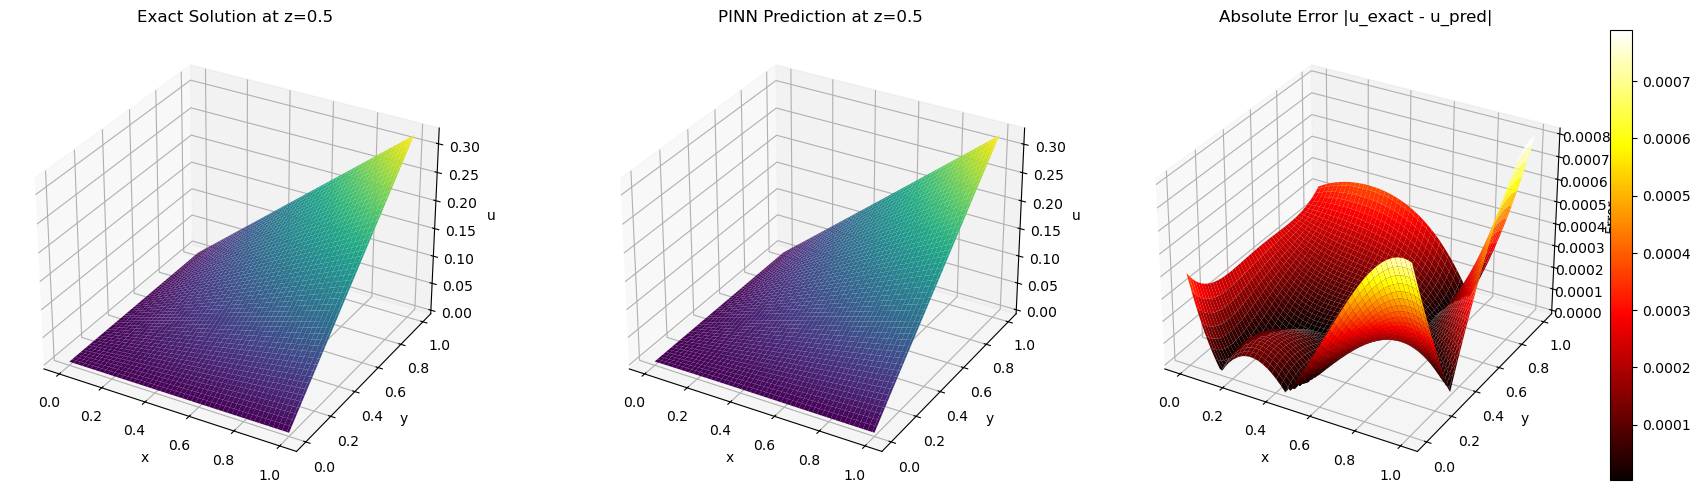

Final L2 relative error: 2.0874e-03


In [5]:
# Generate a grid of points for plotting
x_plot = np.linspace(0, 1, 100)
y_plot = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_plot, y_plot)
Z = np.full(X.shape, 0.5)  

# Prepare input for prediction
plot_points_np = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

# Use exact solution
u_exact = exact_solution_np(X, Y, Z)

# Use DeepXDE model to predict
u_pred = model.predict(plot_points_np).reshape(X.shape)

# Compute absolute error
abs_error = np.abs(u_exact - u_pred)

# Plotting
fig = plt.figure(figsize=(18, 5))

# Exact solution
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, u_exact, cmap='viridis')
ax1.set_title('Exact Solution at z=0.5')
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('u')

# PINN prediction
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, u_pred, cmap='viridis')
ax2.set_title('PINN Prediction at z=0.5')
ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('u')

# Absolute Error
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X, Y, abs_error, cmap='hot')
ax3.set_title('Absolute Error |u_exact - u_pred|')
ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('Error')
fig.colorbar(surf)

plt.tight_layout()
plt.show()

# L2 Relative Error
final_error = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
print(f"Final L2 relative error: {final_error:.4e}")